# Projekt zaliczeniowy

Celem niniejszego projektu jest analiza i poszukiwanie anomalii w danych z datasetu z wyborów w Rosji w 2018 roku oraz nauczenie kilku algorytmów Superviced Learning dla przepowiadania wyników wyborów w lokalach wyborczych. 
Dataset składa się z 23 kolumn:
- region_name: nazwa regionu, w którym znajdował się lokal wyborczy
- tik_name: nazwa terytorialnej komisji wyborczej (często oparta na nazwie dzielnicy)
- uik_name: nazwa lokalu wyborczego (lokalna komisja wyborcza)
- registered_voters: liczba wyborców powiązanych z tym lokalem wyborczym
- received_ballots: liczba pustych kart do głosowania otrzymanych od terytorialnej komisji wyborczej
- early_voting_ballots: liczba kart do głosowania oddanych wyborcom, którzy chcieli głosować przed datą główną
- onsite_ballots: liczba kart do głosowania oddanych wyborcom w lokalu wyborczym
- offsite_ballots: liczba kart do głosowania oddanych wyborcom, którzy chcieli głosować poza miejscem wyborów (głosowanie w domu)
- unused_ballots: liczba kart do głosowania, które były jeszcze niewykorzystane pod koniec dnia wyborów
- found_offsite_ballots: liczba kart do głosowania, które znaleziono w urnach wyborczych poza siedzibą
- found_onsite_ballots: liczba kart do głosowania, które znaleziono w urnach wyborczych w miejscu do głosowania
- invalid_ballots: liczba kart do głosowania uznanych za nieważne (więcej niż jeden wybór, obrazy itp.)
- valid_ballots: liczba kart do głosowania uznanych za ważne (tylko jeden wybór)
- lost_ballots: liczba kart do głosowania, które zostały zgubione (received_ballots - (onsite_ballots + offsite_ballots + unused_ballots))
- unaccounted_ballots: liczba kart do głosowania, która nie została uwzględniona w momencie otrzymania  (-1 * lost_ballots, jeżeli lost_ballots < 0)
- baburin: liczba głosów na Baburina Siergieja Nikołajewicza
- grudinin: liczba głosów na Grudinina Pawła Nikołajewicza
- zhirinovsky: liczba głosów na Żyrinowski'ego Władimira Wolfowicza
- putin: liczba głosów na Putina Władimira Władimirowicza
- sobchak: liczba głosów na Sobczak Ksenię Anatolijewną
- suraykin: liczba głosów na Suraykina Maxima Alexandrovicha
- titov: liczba głosów na Tytowa Borysa Jurjewicza
- yavlinsky: liczba głosów na Yavlinsky'ego Grigoriya Alexeevicha

## Importy potrzebnych modułów

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

/home/vazh/anaconda3/lib/python3.7/site-packages/joblib/_multiprocessing_helpers.py:38: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


## Pobieranie danych

In [3]:
data = pd.read_csv("uiks-utf8.csv")
data.head()

,region_name,tik_name,uik_name,registered_voters,received_ballots,early_voting_ballots,onsite_ballots,offsite_ballots,unused_ballots,found_offsite_ballots,...,lost_ballots,unaccounted_ballots,baburin,grudinin,zhirinovsky,putin,sobchak,suraykin,titov,yavlinsky
0,98 Город Байконур (Республика Казахстан),98 Город Байконур (Республика Казахстан),УИК №8140,2132,2000,0,1447,11,542,11,...,0,0,4,176,79,1136,30,9,5,10
1,98 Город Байконур (Республика Казахстан),98 Город Байконур (Республика Казахстан),УИК №8141,2207,2000,0,1470,14,516,14,...,0,0,2,128,87,1214,19,4,7,9
2,98 Город Байконур (Республика Казахстан),98 Город Байконур (Республика Казахстан),УИК №8142,2249,2000,0,1490,7,503,7,...,0,0,5,171,94,1162,17,3,12,6
3,98 Город Байконур (Республика Казахстан),98 Город Байконур (Республика Казахстан),УИК №8143,1769,1500,0,1065,48,387,48,...,0,0,5,98,72,882,17,8,5,6
4,98 Город Байконур (Республика Казахстан),98 Город Байконур (Республика Казахстан),УИК №8144,1880,1500,0,1171,13,316,13,...,0,0,7,124,105,902,7,9,10,10


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97705 entries, 0 to 97704
Data columns (total 23 columns):
region_name              97705 non-null object
tik_name                 97705 non-null object
uik_name                 97705 non-null object
registered_voters        97705 non-null int64
received_ballots         97705 non-null int64
early_voting_ballots     97705 non-null int64
onsite_ballots           97705 non-null int64
offsite_ballots          97705 non-null int64
unused_ballots           97705 non-null int64
found_offsite_ballots    97705 non-null int64
found_onsite_ballots     97705 non-null int64
invalid_ballots          97705 non-null int64
valid_ballots            97705 non-null int64
lost_ballots             97705 non-null int64
unaccounted_ballots      97705 non-null int64
baburin                  97705 non-null int64
grudinin                 97705 non-null int64
zhirinovsky              97705 non-null int64
putin                    97705 non-null int64
sobchak       

Otrzymany dataset nie zawiera NaN znaczeń, dlatego można przestąpić do analizy danych.

## Ile osób w ogóle brało udział w wyborach?

In [5]:
num_of_pot_vot = data["registered_voters"].sum()
num_of_vot = data["valid_ballots"].sum()
print("W wyborach brało udział {} osób, czyli {r:.2f}% od całej ilości wyborców.".format(num_of_vot, r = 100*num_of_vot/num_of_pot_vot))

W wyborach brało udział 72796250 osób, czyli 66.77% od całej ilości wyborców.


## W których regionach najwięcej i najmniej osób przyszło na wybory?

In [6]:
regions_sum = data.groupby('region_name').sum()
regions_sum['voters_prc'] = regions_sum['valid_ballots']/regions_sum['registered_voters']
regions_sum.sort_values(by = 'voters_prc', ascending =  False)[['registered_voters', 'valid_ballots', 'voters_prc']].head()

,registered_voters,valid_ballots,voters_prc
region_name,,,
99 Территория за пределами РФ,493139,469542,0.952149
Республика Тыва,175102,162780,0.929630
Кабардино-Балкарская Республика,528431,483932,0.915790
Ямало-Ненецкий автономный округ,370823,338067,0.911667
Чеченская Республика,709635,646885,0.911574


In [7]:
regions_sum.sort_values(by = 'voters_prc')[['registered_voters', 'valid_ballots', 'voters_prc']].head()

,registered_voters,valid_ballots,voters_prc
region_name,,,
Иркутская область,1877547,1033973,0.550704
Республика Карелия,519667,293309,0.564417
Новгородская область,502905,284614,0.565940
Тверская область,1070221,609914,0.569895
Забайкальский край,790054,452268,0.572452


Ciekawe jest to, że największy procent wyborców jest dla 99 Terytorium poza Federacją Rosyjską: 95.21% od ilości osób powiązanych z tym regionem.

## Czy całkowita ilość kart wyborczych się zgadza?

Inaczej mówiąc, czy ilość pustych kart wyborczych w lokalach wyborczych zgadza się z sumą ilości kart wyborczych oddanych wyborcom w oraz poza lokalem wyborczym i ilością kart wyborczych niewykorzystanych?

In [8]:
total_number_of_ballots = data["received_ballots"].sum()
total_number_of_used_and_unused_ballots = data["onsite_ballots"].sum() + data["offsite_ballots"].sum() + data["unused_ballots"].sum()
total_number_of_lost = total_number_of_ballots - total_number_of_used_and_unused_ballots
print("Zgubiono około {} kart wyborczych, czyli {r:.2f}% od wszystkich kart wyborczych.".format(total_number_of_lost, r = 100*total_number_of_lost/total_number_of_ballots))

Zgubiono około 221112 kart wyborczych, czyli 0.21% od wszystkich kart wyborczych.


A według kolumny "lost_ballots":

In [9]:
print("Zgubiono około {} kart wyborczych, czyli {r:.3f}% od wszystkich kart wyborczych.".format(data["lost_ballots"].sum(), r = 100*data["lost_ballots"].sum()/total_number_of_ballots))

Zgubiono około 1049 kart wyborczych, czyli 0.001% od wszystkich kart wyborczych.


Czyli kolumna "lost_ballots" została stworzona niepoprawnie. Ponadto, nie ma sensu kolumna "unaccounted_ballots", bo według podanej definicji: -1 * lost_ballots jeżeli lost_ballots < 0:

In [10]:
data[data["lost_ballots"]<0]

,region_name,tik_name,uik_name,registered_voters,received_ballots,early_voting_ballots,onsite_ballots,offsite_ballots,unused_ballots,found_offsite_ballots,...,lost_ballots,unaccounted_ballots,baburin,grudinin,zhirinovsky,putin,sobchak,suraykin,titov,yavlinsky


Czyli nie ma ujemnych wartości, dlatego nie powinno być żadnych wartości w "unaccounted_ballots".

In [11]:
data["unaccounted_ballots"].sum()

104

Jednak one są. Wszystko się sprowadza do tego, że kolumna "lost_ballots" została źle stworzona. Dlatego powtórnie stworzono kolumnę "lost_ballots" według podanej definincji: lost_ballots = received_ballots - (onsite_ballots + offsite_ballots + unused_ballots).

In [12]:
data["lost_ballots"] = data["received_ballots"] - data["onsite_ballots"] - data["offsite_ballots"] - data["unused_ballots"]

I powtórnie sprawdzono, jak to wygląda według kolumny "lost_ballots":

In [13]:
print("Zgubiono około {} kart wyborczych, czyli {r:.2f}% od wszystkich kart wyborczych".format(data["lost_ballots"].sum(), r = 100*data["lost_ballots"].sum()/total_number_of_ballots))

Zgubiono około 221112 kart wyborczych, czyli 0.21% od wszystkich kart wyborczych


Czyli, teraz wynik jest poprawny. Ponadto powtórnie stworzono kolumnę "unaccounted_ballots" według podanej definicji: -1 * lost_ballots jeżeli lost_ballots < 0.

In [14]:
data["unaccounted_ballots"] = data["lost_ballots"].apply(lambda x: -x if x<0 else 0)
data["unaccounted_ballots"].sum()

40

## Jak wygląda sytuacja z ilościami głosów na kandydatów?

In [15]:
data.columns

Index(['region_name', 'tik_name', 'uik_name', 'registered_voters',
       'received_ballots', 'early_voting_ballots', 'onsite_ballots',
       'offsite_ballots', 'unused_ballots', 'found_offsite_ballots',
       'found_onsite_ballots', 'invalid_ballots', 'valid_ballots',
       'lost_ballots', 'unaccounted_ballots', 'baburin', 'grudinin',
       'zhirinovsky', 'putin', 'sobchak', 'suraykin', 'titov', 'yavlinsky'],
      dtype='object')

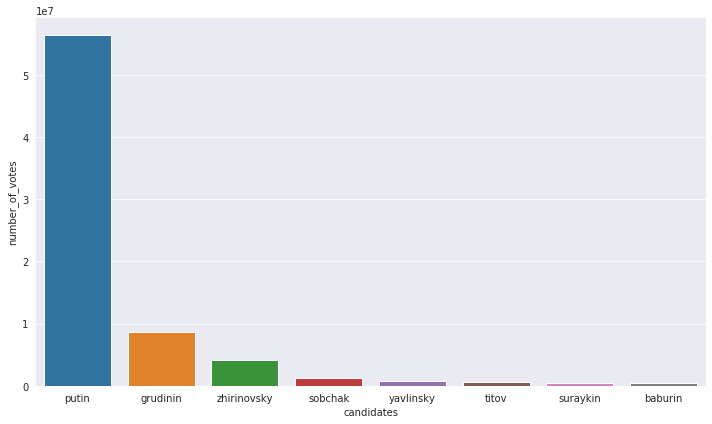

In [4]:
col_with_cand = ['baburin', 'grudinin',
       'zhirinovsky', 'putin', 'sobchak', 'suraykin', 'titov', 'yavlinsky']
number_of_votes = [data[col].sum() for col in col_with_cand]
results_votes = pd.DataFrame()
results_votes['number_of_votes'] = number_of_votes
results_votes['candidates'] = col_with_cand
results_votes.sort_values(by = "number_of_votes", ascending = False, inplace = True)
sns.set_style('darkgrid')
fig = plt.figure(figsize = (10,6))
sns.barplot(x = 'candidates', y = 'number_of_votes', data = results_votes)
plt.tight_layout()

Pierwsze miejsce zajmuje Putin Władimir Władimirowicz, który ma zdecydowanie większą ilość głosów w porównaniu do innych kandydatów. Następnie idzie Grudinin Paweł Nikołajewicz oraz Baburin Siergiej Nikołajewicz. Inni kandydaci mają znacznie mniej głosów.

## W ilu lokalach wyborczych zajmuje pierwsze miejsce każdy kandydat?

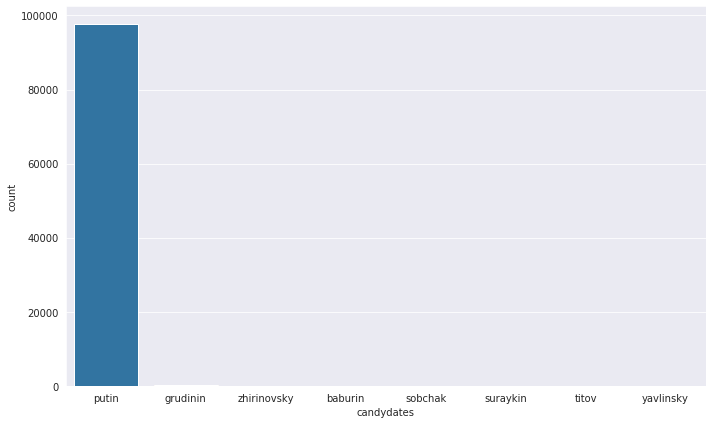

In [17]:
start_count = np.zeros(8, dtype = int)

results_by_uik =  pd.DataFrame(index = col_with_cand)
results_by_uik["count"] = start_count
for index in data.index:
    max_index = data[col_with_cand].iloc[index].idxmax()
    results_by_uik.loc[max_index]+=1
results_by_uik.reset_index(inplace = True)
results_by_uik.columns = ['candydates', 'count']
results_by_uik.sort_values(by = "count", ascending = False, inplace = True)
sns.set_style('darkgrid')
fig = plt.figure(figsize = (10,6))
sns.barplot(x = 'candydates', y = 'count', data = results_by_uik)
plt.tight_layout()

In [18]:
print("Władimir Putin zajmuje pierwsze miejsce w {}, czyli {r:.2f}% od ilości wszystkich lokali wyborczych.".format(results_by_uik[results_by_uik['candydates']== 'putin']['count'].iloc[0], r = 100*results_by_uik[results_by_uik['candydates']== 'putin']['count'].iloc[0]/results_by_uik['count'].sum()))

Władimir Putin zajmuje pierwsze miejsce w 97566, czyli 99.86% od ilości wszystkich lokali wyborczych.


In [19]:
results_by_uik.head()

,candydates,count
3,putin,97566
1,grudinin,100
2,zhirinovsky,36
0,baburin,3
4,sobchak,0


Czyli tylko w 139 innych lokalach wyborczych wygrywa inny kandydat.

## W ilu lokalach wyborczych zajmuje drugie miejsce każdy kandydat?

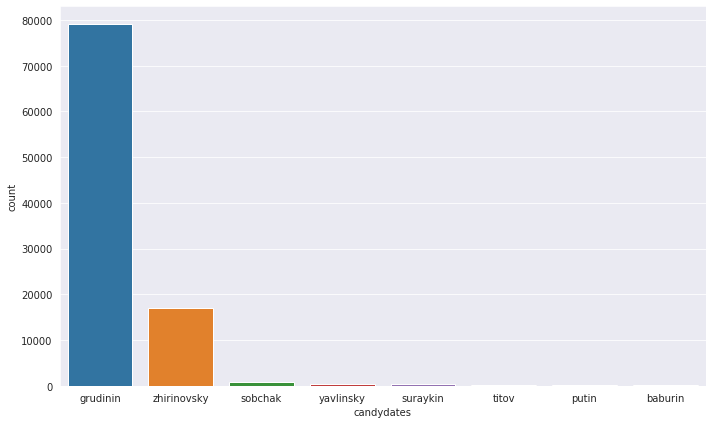

In [20]:
start_count = np.zeros(8, dtype = int)
results_by_uik_sec =  pd.DataFrame(index = col_with_cand)
results_by_uik_sec["count"] = start_count
for index in data.index:
    sec_max_index = data[col_with_cand].iloc[index].sort_values(ascending = False).index[1]
    results_by_uik_sec.loc[sec_max_index]+=1
results_by_uik_sec.reset_index(inplace = True)
results_by_uik_sec.columns = ['candydates', 'count']
results_by_uik_sec.sort_values(by = "count", ascending = False, inplace = True)
sns.set_style('darkgrid')
fig = plt.figure(figsize = (10,6))
sns.barplot(x = 'candydates', y = 'count', data = results_by_uik_sec)
plt.tight_layout()

In [21]:
print("Paweł Grudinin zajmuje drugie miejsce w {}, czyli {r:.2f}% od ilości wszystkich lokali wyborczych.".format(results_by_uik_sec[results_by_uik_sec['candydates']== 'grudinin']['count'].iloc[0], r = 100*results_by_uik_sec[results_by_uik_sec['candydates']== 'grudinin']['count'].iloc[0]/results_by_uik_sec['count'].sum()))

Paweł Grudinin zajmuje drugie miejsce w 79017, czyli 80.87% od ilości wszystkich lokali wyborczych.


In [22]:
results_by_uik_sec.head()

,candydates,count
1,grudinin,79017
2,zhirinovsky,16928
4,sobchak,778
7,yavlinsky,380
5,suraykin,295


W przypadku drugiego miejsca sytuacja wygląda bardziej interesująco, niekwestionowanym liderem jest Grudinin Paweł Nikołajewicz.

## Analiza lokali wyborczych, w których Władimir Putin wygrał i przegrał

Podział oryginalnego datasetu na dwa:
- Dataset, w którym podane są wszystkie lokale wyborcze, w których Władimir Putin wygrał
- Dataset, w którym podane są wszystkie lokale wyborcze, w których Władimir Putin nie zajął pierwsze miejsce

In [5]:
data_win = data.copy()
data_lose = data.copy()
for index in data.index:
    max_index = data[col_with_cand].iloc[index].idxmax()
    if max_index == 'putin':
        data_lose.drop(index, inplace = True)
    else:
        data_win.drop(index, inplace = True)
        

Sprawdzenie ile procent osób postanowiło głosować przed datą główną:

In [26]:
print("W wygranych lokalach wyborczych: {r:.2f}%.".format(r = 100*data_win['early_voting_ballots'].sum() / (data_win['found_onsite_ballots'].sum() + data_win['found_offsite_ballots'].sum())))

W wygranych lokalach wyborczych: 0.30%.


In [27]:
print("W przegranych lokalach wyborczych: {r:.2f}%.".format(r = 100*data_lose['early_voting_ballots'].sum() / (data_lose['found_onsite_ballots'].sum() + data_lose['found_offsite_ballots'].sum())))

W przegranych lokalach wyborczych: 0.22%.


Różnica jest niewielka.

Sprawdzenie ile procent wszystkich kart wyborczych zgubiono:

In [28]:
print("W wygranych lokalach wyborczych: {r:.2f}%.".format(r = 100*data_win['early_voting_ballots'].sum() / (data_win['lost_ballots'].sum() + data_win['offsite_ballots'].sum() + data_win['unused_ballots'].sum())))

W wygranych lokalach wyborczych: 0.64%.


In [29]:
print("W przegranych lokalach wyborczych: {r:.2f}%.".format(r = 100*data_lose['lost_ballots'].sum() / (data_lose['onsite_ballots'].sum() + data_lose['offsite_ballots'].sum() + data_lose['unused_ballots'].sum())))

W przegranych lokalach wyborczych: 0.19%.


W przypadku wygranych lokalach wyborczych jest prawie trzykrotnie większa ilość zgubionych kart wyborczych.

Sprawdzenie ile procent od wszystkich wyborców postanowiło głosować w lokalach wyborczy i ile z nich postanowiło głosować w lokalu, a ile poza lokalem:

In [30]:
print("W wygranych lokalach wyborczych przegłosowało: {r:.2f}% od całej ilości wyborców.".format(r = 100 * (data_win['found_onsite_ballots'].sum() + data_win['found_offsite_ballots'].sum())/data_win['registered_voters'].sum()))
print("W wygranych lokalach wyborczych: {r:.2f}% głosowało w siedzibie.".format(r = 100*data_win['found_onsite_ballots'].sum() / (data_win['found_onsite_ballots'].sum() + data_win['found_offsite_ballots'].sum())))
print("W wygranych lokalach wyborczych: {r:.2f}% głosowało poza siedzibą.".format(r = 100*data_win['found_offsite_ballots'].sum() / (data_win['found_onsite_ballots'].sum() + data_win['found_offsite_ballots'].sum())))

W wygranych lokalach wyborczych przegłosowało: 67.49% od całej ilości wyborców.
W wygranych lokalach wyborczych: 93.15% głosowało w siedzibie.
W wygranych lokalach wyborczych: 6.85% głosowało poza siedzibą.


In [31]:
print("W przegranych lokalach wyborczych przegłosowało: {r:.2f}% od całej ilości wyborców".format(r = 100 * (data_lose['found_onsite_ballots'].sum() + data_lose['found_offsite_ballots'].sum())/data_lose['registered_voters'].sum()))
print("W przegranych lokalach wyborczych: {r:.2f}% głosowało w siedzibie.".format(r = 100*data_lose['found_onsite_ballots'].sum() / (data_lose['found_onsite_ballots'].sum() + data_lose['found_offsite_ballots'].sum())))
print("W przegranych lokalach wyborczych: {r:.2f}% głosowało poza siedzibą.".format(r = 100*data_lose['found_offsite_ballots'].sum() / (data_lose['found_onsite_ballots'].sum() + data_lose['found_offsite_ballots'].sum())))

W przegranych lokalach wyborczych przegłosowało: 81.24% od całej ilości wyborców
W przegranych lokalach wyborczych: 93.99% głosowało w siedzibie.
W przegranych lokalach wyborczych: 6.01% głosowało poza siedzibą.


Czyli w lokalach wyborczych, w których Putin nie zajął pierwsze miejsce, głosowało na około 14% więcej od całej ilości wyborców zarejestrowanych w tych lokalach wyborczych.

Sprawdzenie, czy są takie lokale wyborcze, w których głosowali tylko na Władimira Putina.

In [6]:
data_win[data_win['putin'] == data_win['valid_ballots']].shape

(238, 23)

Czyli są 238 takich lokali wyborczych.

In [33]:
votes_only_for_putin = data_win[data_win['putin'] == data_win['valid_ballots']]['putin'].sum()
print("W 238 lokalach wyborczych glosowali tylko na Władimira Putina, co daje {} głosów, albo {r:.2f}% od całej ilości głosów oddanych na Władimira Putina.".format(votes_only_for_putin, r =100*votes_only_for_putin/results_votes.loc[3]['number_of_votes']))

W 238 lokalach wyborczych glosowali tylko na Władimira Putina, co daje 24593 głosów, albo 0.04% od całej ilości głosów oddanych na Władimira Putina.


Sprawdzenie, czy istnieją podobne lokale wyborcze dla innych kandydatów.

In [34]:
for cand in col_with_cand:
    if cand!='putin':
        data_lose[data_lose[cand] == data_lose['valid_ballots']].shape

Czyli nie ma takich lokali wyborczych dla innych kandydatów.

# Część Machine Learning

W niniejszej części spróbowano użycie metody Superviced Learning dla przepowiadania wyników wyborów. W tym celu będą używane następne kolumny z oryginalnego datasetu:
- registered_voters
- received_ballots
- early_voting_ballots
- onsite_ballots
- offsite_ballots
- unused_ballots
- found_offsite_ballots
- found_onsite_ballots
- invalid_ballots
- valid_ballots
- lost_ballots
    

Dla użycia niektórych cech należy przeprowadzić zmianę kolumn tekstowych na liczby.
W celu uproszczenia danych wejściowych tylko nazwa regionu będzie uwzględniona. Dla użycia tych danych należy zamienić tekst na liczby.

In [35]:
data['region_name'].nunique()

87

Skoro jest 87 unikalnych wartości, to każda unikalna wartość zostanie zmieniona na liczbę od 1 do 87. 
Jako wartości, które niniejsze algorytmy będą starały się prewidzieć, to jaki kandydat w konkretnym lokalu wyborczym będzie zajmował odpowiednio pierwsze, drugie i trzecie miejsce. Dlatego zamiast kolumn z ilością głosów na konkretnego kandydata będą stworzone kolumny First_Place, Second_Place, Third_Place, których wartościami będą odpowiednio nazwa kandydata, który to miejsce zajmuje, reprezentowany jako liczba:
- baburin: 1
- grudinin: 2
- zhirinovsky: 3
- putin: 4
- sobchak: 5
- suraykin: 6
- titov: 7
- yavlinsky: 8

## Kopiowanie oryginalnego datasetu i usunięcie niepotrzebnych kolumn

In [7]:
data_ml = data.copy()
data.columns

Index(['region_name', 'tik_name', 'uik_name', 'registered_voters',
       'received_ballots', 'early_voting_ballots', 'onsite_ballots',
       'offsite_ballots', 'unused_ballots', 'found_offsite_ballots',
       'found_onsite_ballots', 'invalid_ballots', 'valid_ballots',
       'lost_ballots', 'unaccounted_ballots', 'baburin', 'grudinin',
       'zhirinovsky', 'putin', 'sobchak', 'suraykin', 'titov', 'yavlinsky'],
      dtype='object')

In [8]:
data_ml.drop(['tik_name', 'uik_name', 'unaccounted_ballots' ], axis = 1, inplace = True)

## Przekształcenie danych

In [38]:
uniq = {}
candydate = {
    'baburin': 1, 'grudinin': 2, 'zhirinovsky': 3, 'putin': 4, 'sobchak': 5, 'suraykin': 6, 'titov': 7, 
    'yavlinsky': 8}
data_ml['First_Place'] = ""
data_ml['Second_Place'] = ""
data_ml['Third_Place'] = ""    
i = 0

for region in data_ml['region_name'].unique():
    uniq[region] = i
    i+=1

for index in data_ml.index:
    data_ml['region_name'].iloc[index] = uniq[data_ml['region_name'].iloc[index]]
    temp = data_ml[col_with_cand].iloc[index].sort_values(ascending = False)
    first = temp.index[0]
    second = temp.index[1]
    third = temp.index[2]
    data_ml['First_Place'].iloc[index] = candydate[first]
    data_ml['Second_Place'].iloc[index] = candydate[second]
    data_ml['Third_Place'].iloc[index] = candydate[third]

data_ml.head()    

/home/vazh/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,region_name,registered_voters,received_ballots,early_voting_ballots,onsite_ballots,offsite_ballots,unused_ballots,found_offsite_ballots,found_onsite_ballots,invalid_ballots,...,grudinin,zhirinovsky,putin,sobchak,suraykin,titov,yavlinsky,First_Place,Second_Place,Third_Place
0,0,2132,2000,0,1447,11,542,11,1447,9,...,176,79,1136,30,9,5,10,4,2,3
1,0,2207,2000,0,1470,14,516,14,1470,14,...,128,87,1214,19,4,7,9,4,2,3
2,0,2249,2000,0,1490,7,503,7,1490,27,...,171,94,1162,17,3,12,6,4,2,3
3,0,1769,1500,0,1065,48,387,48,1065,20,...,98,72,882,17,8,5,6,4,2,3
4,0,1880,1500,0,1171,13,316,13,1171,10,...,124,105,902,7,9,10,10,4,2,3



## Usunięcie niepotrzebnych kolumn i podział danych na train i test sety

In [39]:
from sklearn.model_selection import train_test_split

data_ml.drop(col_with_cand, axis = 1, inplace = True)
X_train, X_test, Y_train, Y_test = train_test_split(data_ml.drop(['First_Place', 'Second_Place', 'Third_Place'], axis = 1), data_ml[['First_Place', 'Second_Place', 'Third_Place']], test_size = 0.3)

## Nauczenie algorytmów dla przepowiadania kto zajmie pierwsze miejsce w konkretnym lokalu wyborczym

Ze względu na to, że w 99.86% od ilości wszystkich lokali wyborczych pierwsze miejsce zajmuje Władimir Putin, nauczenie algorytmu staje się zadaniem dość trywialnym. Jednak pojawia się pytanie, czy nauczone algorytmy będą w stanie przypisać jakichkolwiek innych kandydatów jako wygranych, czy wszędzie będzie Władimir Putin?

We wszystkich poniżej przeprowadzonych analizach postanowiono użyć 4 różne metody Superviced Learning: Logistic Regression, K Nearest Neighbots, Random Forest i Support Vector Clusters.

** Nauczenie algorytmów

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

model_LR = LogisticRegression()
model_KN = KNeighborsClassifier(n_neighbors = 5)
model_RF = RandomForestClassifier(n_estimators=100)
model_SVC= SVC()

model_LR.fit(X_train, Y_train['First_Place'])
model_KN.fit(X_train, Y_train['First_Place'])
model_RF.fit(X_train, Y_train['First_Place'])
model_SVC.fit(X_train, Y_train['First_Place'])

/home/vazh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vazh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/vazh/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

** Sprawdzenie działania algorytmów na danych testowych

In [41]:
predict_LR = model_LR.predict(X_test)
predict_KN = model_KN.predict(X_test)
predict_RF = model_RF.predict(X_test)
predict_SVC = model_SVC.predict(X_test)

** Analiza wyników

In [42]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(Y_test['First_Place'], predict_LR, digits = 4))

              precision    recall  f1-score   support

           2     0.0000    0.0000    0.0000        31
           3     0.0000    0.0000    0.0000         7
           4     0.9987    0.9999    0.9993     29273
           5     0.0000    0.0000    0.0000         0
           8     0.0000    0.0000    0.0000         1

    accuracy                         0.9986     29312
   macro avg     0.1997    0.2000    0.1999     29312
weighted avg     0.9973    0.9986    0.9980     29312



/home/vazh/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/vazh/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [43]:
print(classification_report(Y_test['First_Place'], predict_KN, digits = 4))

              precision    recall  f1-score   support

           2     0.0000    0.0000    0.0000        31
           3     0.0000    0.0000    0.0000         7
           4     0.9987    1.0000    0.9993     29273
           8     0.0000    0.0000    0.0000         1

    accuracy                         0.9987     29312
   macro avg     0.2497    0.2500    0.2498     29312
weighted avg     0.9973    0.9987    0.9980     29312



In [44]:
print(classification_report(Y_test['First_Place'], predict_RF, digits = 4))

              precision    recall  f1-score   support

           2     0.0000    0.0000    0.0000        31
           3     0.0000    0.0000    0.0000         7
           4     0.9987    0.9999    0.9993     29273
           7     0.0000    0.0000    0.0000         0
           8     0.0000    0.0000    0.0000         1

    accuracy                         0.9985     29312
   macro avg     0.1997    0.2000    0.1999     29312
weighted avg     0.9974    0.9985    0.9980     29312



In [45]:
print(classification_report(Y_test['First_Place'], predict_SVC, digits = 4))

              precision    recall  f1-score   support

           2     0.0000    0.0000    0.0000        31
           3     0.0000    0.0000    0.0000         7
           4     0.9987    1.0000    0.9993     29273
           8     0.0000    0.0000    0.0000         1

    accuracy                         0.9987     29312
   macro avg     0.2497    0.2500    0.2498     29312
weighted avg     0.9973    0.9987    0.9980     29312



We wszystkich użytych algorytmach dokładność 99.87% jest dla wartości 4, co odpowiada Władimirowi Putinowi. Jednak dla wszystkich innych kandydatów dokładność wynosi 00.00%, co oznacza, że użyte algorytmy nie są w stanie przewidzieć żaden inny wynik dla lokali wyborczych.

## Nauczenie algorytmów dla przepowiadania kto zajmie drugie miejsce w konkretnym lokalu wyborczym

W przypadku drugiego miejsca pojawia się już konkurencja. Na tle innych kandydatów wyróżniają się: Grudinin Paweł Nikołajewicz i Żyrinowski Władimir Wolfowicz.

** Nauczenie algorytmów

In [46]:
model_LR_sec = LogisticRegression()
model_KN_sec = KNeighborsClassifier(n_neighbors = 5)
model_RF_sec = RandomForestClassifier(n_estimators=100)
model_SVC_sec= SVC()

model_LR_sec.fit(X_train, Y_train['Second_Place'])
model_KN_sec.fit(X_train, Y_train['Second_Place'])
model_RF_sec.fit(X_train, Y_train['Second_Place'])
model_SVC_sec.fit(X_train, Y_train['Second_Place'])

/home/vazh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vazh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/vazh/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/vazh/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

** Sprawdzenie działania algorytmów na danych testowych

In [47]:
predict_LR_sec = model_LR_sec.predict(X_test)
predict_KN_sec = model_KN_sec.predict(X_test)
predict_RF_sec = model_RF_sec.predict(X_test)
predict_SVC_sec = model_SVC_sec.predict(X_test)

** Analiza wyników

In [48]:
print(classification_report(Y_test['Second_Place'], predict_LR_sec))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        23
           2       0.81      1.00      0.90     23772
           3       0.53      0.00      0.00      5018
           4       0.00      0.00      0.00        32
           5       0.57      0.02      0.03       239
           6       0.00      0.00      0.00        93
           7       0.00      0.00      0.00        31
           8       0.00      0.00      0.00       104

    accuracy                           0.81     29312
   macro avg       0.24      0.13      0.12     29312
weighted avg       0.75      0.81      0.73     29312



/home/vazh/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [49]:
print(classification_report(Y_test['Second_Place'], predict_KN_sec))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        23
           2       0.84      0.93      0.88     23772
           3       0.42      0.26      0.32      5018
           4       0.29      0.06      0.10        32
           5       0.43      0.04      0.08       239
           6       0.50      0.04      0.08        93
           7       0.00      0.00      0.00        31
           8       0.31      0.08      0.12       104

    accuracy                           0.80     29312
   macro avg       0.35      0.18      0.20     29312
weighted avg       0.76      0.80      0.77     29312



In [50]:
print(classification_report(Y_test['Second_Place'], predict_RF_sec))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        23
           2       0.85      0.95      0.90     23772
           3       0.51      0.27      0.35      5018
           4       0.17      0.03      0.05        32
           5       0.43      0.10      0.16       239
           6       0.67      0.11      0.19        93
           7       0.00      0.00      0.00        31
           8       0.31      0.13      0.19       104

    accuracy                           0.82     29312
   macro avg       0.37      0.20      0.23     29312
weighted avg       0.78      0.82      0.79     29312



In [51]:
print(classification_report(Y_test['Second_Place'], predict_SVC_sec))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        23
           2       0.81      1.00      0.90     23772
           3       0.55      0.02      0.03      5018
           4       0.00      0.00      0.00        32
           5       0.00      0.00      0.00       239
           6       0.00      0.00      0.00        93
           7       0.00      0.00      0.00        31
           8       0.41      0.09      0.14       104

    accuracy                           0.81     29312
   macro avg       0.22      0.14      0.13     29312
weighted avg       0.76      0.81      0.73     29312



Dokładność wszystkich użytych algorytmów wynosi co najmniej 80%. Najsłabszymi algorytmami okazały się Logistic Regression oraz Support Vector Clusters: ma 0.00% dokładności dla 5 kandydatów. Najlepszym modelem jest Random Forest(ma 82% dokładności ogólnej oraz 0.00% dokładności dla 2 kandydatów). Trochę gorzej jest dla K Nearest Neighbors (ma 80% dokładności ogólnej, 0.00% dokładności dla 2 kandydatów i niektóre wartości gorsze niż w przypadku RF).

## Nauczenie algorytmów dla przepowiadania kto zajmie trzecie miejsce w konkretnym lokalu wyborczym

Również postanowiono przeprowadzić analogiczną analizę dla trzeciego miejsca.


** Nauczenie algorytmów

In [52]:
model_LR_thr = LogisticRegression()
model_KN_thr = KNeighborsClassifier(n_neighbors = 5)
model_RF_thr = RandomForestClassifier(n_estimators=100)
model_SVC_thr= SVC()

model_LR_thr.fit(X_train, Y_train['Third_Place'])
model_KN_thr.fit(X_train, Y_train['Third_Place'])
model_RF_thr.fit(X_train, Y_train['Third_Place'])
model_SVC_thr.fit(X_train, Y_train['Third_Place'])

/home/vazh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vazh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/vazh/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

** Sprawdzenie działania algorytmów na danych testowych

In [53]:
predict_LR_thr = model_LR_thr.predict(X_test)
predict_KN_thr = model_KN_thr.predict(X_test)
predict_RF_thr = model_RF_thr.predict(X_test)
predict_SVC_thr = model_SVC_thr.predict(X_test)

** Analiza wyników

In [54]:
print(classification_report(Y_test['Third_Place'], predict_LR_thr))

              precision    recall  f1-score   support

           1       0.20      0.01      0.01       163
           2       0.56      0.00      0.01      4802
           3       0.73      1.00      0.84     21288
           4       0.00      0.00      0.00         5
           5       0.08      0.00      0.00      1605
           6       0.00      0.00      0.00       380
           7       0.00      0.00      0.00       280
           8       0.00      0.00      0.00       789

    accuracy                           0.73     29312
   macro avg       0.20      0.13      0.11     29312
weighted avg       0.63      0.73      0.61     29312



/home/vazh/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [55]:
print(classification_report(Y_test['Third_Place'], predict_KN_thr))

              precision    recall  f1-score   support

           1       0.15      0.17      0.16       163
           2       0.34      0.28      0.31      4802
           3       0.78      0.89      0.83     21288
           4       0.00      0.00      0.00         5
           5       0.24      0.05      0.09      1605
           6       0.07      0.01      0.02       380
           7       0.16      0.05      0.08       280
           8       0.27      0.11      0.16       789

    accuracy                           0.70     29312
   macro avg       0.25      0.20      0.20     29312
weighted avg       0.64      0.70      0.66     29312



In [56]:
print(classification_report(Y_test['Third_Place'], predict_RF_thr))

              precision    recall  f1-score   support

           1       0.46      0.24      0.32       163
           2       0.42      0.25      0.31      4802
           3       0.78      0.92      0.85     21288
           4       0.00      0.00      0.00         5
           5       0.41      0.17      0.24      1605
           6       0.15      0.03      0.06       380
           7       0.21      0.09      0.12       280
           8       0.33      0.16      0.22       789

    accuracy                           0.73     29312
   macro avg       0.35      0.23      0.26     29312
weighted avg       0.68      0.73      0.69     29312



In [57]:
print(classification_report(Y_test['Third_Place'], predict_SVC_thr))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       163
           2       0.36      0.01      0.02      4802
           3       0.73      1.00      0.84     21288
           4       0.00      0.00      0.00         5
           5       0.25      0.00      0.00      1605
           6       0.00      0.00      0.00       380
           7       0.32      0.02      0.04       280
           8       0.48      0.02      0.03       789

    accuracy                           0.73     29312
   macro avg       0.27      0.13      0.12     29312
weighted avg       0.62      0.73      0.62     29312



Ogólna dokładność jest na poziomie rzędu 70%.
Najgorszym modelem okazał się Logistic Regression: 0.00% dokładności jest dla 4 kandydatów. Trochę lepiej jest dla Support Vector Clusters: 0.00% dokładności dla 3 kandydatów.
Najlepszymi modelami okazały się: K Nearest Neighbors (ogólna dokładność 70%) oraz Random Forest (ogólna dokładność 73% oraz są lepsze wyniki dla innych parametrów niż w przypadku KN).

## PODSUMOWANIE

Przeprowadzono analizę danych z wyborów w Rosji w 2018 roku. W wyborach brało udział 72796250 osób, czyli 66.77% od całej ilości wyborców. Pierwsze miejsce zajmuje Putin Władimir Władimirowicz, który ma zdecydowanie większą ilość głosów w porównaniu do innych kandydatów. Następnie idzie Grudinin Paweł Nikołajewicz oraz Baburin Siergiej Nikołajewicz. Inni kandydaci mają znacznie mniej głosów. Zauważono następujące anomalie:
 - największy procent wyborców jest dla 99 Terytorium poza Federacją Rosyjską: 95.21% od ilości osób powiązanych z tym regionem.
 - zgubiono około 221112 kart wyborczych, czyli 0.21% od wszystkich kart wyborczych. Według danych z otrzymanego datasetu wynikało, że zgubiono około 1049 kart wyborczych, czyli 0.001% od wszystkich kart wyborczych.
 - Władimir Putin zajmuje pierwsze miejsce w 97566, czyli 99.86% od ilości wszystkich lokali wyborczych. Tylko w 139 innych lokalach wyborczych wygrywa inny kandydat. W przypadku drugiego miejsca sytuacja wygląda bardziej interesująco, niekwestionowanym liderem jest Grudinin Paweł Nikołajewicz.
 - w 238 lokalach wyborczych glosowali tylko na Władimira Putina, co daje 24593 głosów, albo 0.04% od całej ilości głosów oddanych na Władimira Putina. Dla pozostałych kandydatów nie ma takich lokali wyborczych. 

Ponadto przeprowadzono analizę lokali wyborczych, w których Władimir Putin wygrał i przegrał:
 - W wygranych lokalach wyborczych postanowiło głosować przed datą główną 0.30% od całej ilości osób, a w przegranych lokalach wyborczych 0.22%.
 - W przypadku wygranych lokalach wyborczych jest prawie trzykrotnie większa ilość zgubionych kart wyborczych.
 - W lokalach wyborczych, w których Władimi Putin nie zajął pierwsze miejsce, głosowało na około 14% więcej od całej ilości wyborców zarejestrowanych w tych lokalach wyborczych.
 
Podjęto próbę użycia metody Superviced Learning dla przepowiadania wyników wyborów. Jako wartości, które niniejsze algorytmy starały się prewidzieć, to jaki kandydat w konkretnym lokalu wyborczym będzie zajmował odpowiednio pierwsze, drugie i trzecie miejsce. We wszystkich przeprowadzonych analizach postanowiono użyć 4 różne metody Superviced Learning: Logistic Regression, K Nearest Neighbots, Random Forest i Support Vector Clusters. Otrzymano następujące wyniki:
 - dla pierwszego miejsca wszystkie użyte algorytmy z dokładnością 99.87% przepowiadały wygranie Władimira Putina. Jednak dla pozostałych kandydatów dokładność wynosi 00.00%, co oznacza, że użyte algorytmy nie są w stanie przewidzieć żaden inny wynik dla lokali wyborczych.
 - dla drugiego miejsca dokładność wszystkich użytych algorytmów wynosiła co najmniej 80%. Najsłabszymi algorytmami okazały się Logistic Regression oraz Support Vector Clusters. Najlepszym modelem jest Random Forest(ma 82% dokładności ogólnej). Trochę gorzej jest dla K Nearest Neighbors (ma 80% dokładności ogólnej i niektóre wartości gorsze niż w przypadku RF).
 - dla trzecigo miejsca ogólna dokładność użytych algorytmów była na poziomie rzędu 70%. Najgorszym modelem okazał się Logistic Regression: 0.00% dokładności jest dla 4 kandydatów. Trochę lepiej jest dla Support Vector Clusters: 0.00% dokładności dla 3 kandydatów. Najlepszymi modelami okazały się: K Nearest Neighbors (ogólna dokładność 70%) oraz Random Forest (ogólna dokładność 73% oraz są lepsze wyniki dla innych parametrów niż w przypadku KN).

Na podstawie powyższych rozważań stwierdzono, że najlepszym i uniwersalnym algorytmem dla tego typu problemu jest Random Forest, chociaż również dobrze można użyć K Nearest Neighbors (jest możliwe, że można by było znaleść lepszą liczbę K, która poprawiłaby dokładność, jednak to nie zostało zrobiono ze względu na duży czas obliczeniowy).